In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import datetime
import numpy as np

wd='/vegas/users/staff/womo1998/corona_weimar.txt'

full_list=np.arange(np.datetime64('2021-02-02',"D"),np.datetime64(datetime.datetime.today(),"D")+1)
num_all = full_list.size

cum_inf=[None for _ in range(num_all)]
act_inf=[None for _ in range(num_all)]
rec=[None for _ in range(num_all)]
deaths=[None for _ in range(num_all)]
hosp=[None for _ in range(num_all)]
quar=[None for _ in range(num_all)]
inc=[None for _ in range(num_all)]
causes=[None for _ in range(num_all)]
rapid_test=[None for _ in range(num_all)]
i=-1
full_lines=[]
with open(wd) as f:
    for line in f.readlines():
        if not line:
            continue
        elif line.startswith('Die aktuellen Weimarer Zahlen\n'):
            full_lines.append(line)
        else:
            full_lines[-1]+=line

for full_line in full_lines:
    
    m=re.search('Stand:* [0-9]{1,2}.[0-9]{1,2}.[0-9]{4}', full_line)
    if m: 
        date_str = m.group().lstrip('Stand\: ')
        day,month,year = [int(num) for num in date_str.strip('').split('.')]
        this_date = np.datetime64(f'{year}-{month:02d}-{day:02d}', 'D')
        i = np.where(full_list==this_date)[0][0]
    else:
        print(full_line)
    m=re.search('positiv Getesteten\: [0-9]\.[0-9]{3}',full_line)
    if m: cum_inf[i]=int(m.group().lstrip('positiv Getesteten\: ').replace('.',''))
    m=re.search('aktuell Infizierten\: [0-9]{1,3}',full_line)
    if m:act_inf[i]=int(m.group().lstrip('aktuell Infizierten\: '))
    m=re.search('Genesenen\: [0-9]{1,4}',full_line)
    if m:rec[i]=int(m.group().lstrip('Genesenen\: '))
    m=re.search('Verstorbenen\: [0-9]{1,4}',full_line)
    if m:deaths[i]=int(m.group().lstrip('Verstorbenen\: '))
    m=re.search('Behandelten\: [0-9]{1,4}',full_line)
    if m:hosp[i]=int(m.group().lstrip('Behandelten\: '))
    m=re.search('Quarantäne\: [0-9]{1,4}',full_line)
    if m:quar[i]=int(m.group().lstrip('Quarantäne\: '))
    m=re.search('Inzidenz.*\: [0-9]{1,3}\,[0-9]{1,2}',full_line)
    if m:inc[i]=float(re.search('[0-9]{1,3}\,[0-9]{1,2}',m.group()).group().lstrip('Uhr\)\: ').replace(',','.'))
    m=re.search('Schnelltests.* ([0-9]\.)?[0-9]{1,4}',full_line)
    if m:rapid_test[i]=int(re.search('([0-9]\.)?[0-9]{1,4}',m.group()).group().replace('.',''))
    m=re.search('Ansteckungsursache.*',full_line)
    if m:causes[i]=m.group()

            
cum_inf = np.array(cum_inf)
cum_inf[cum_inf==None]=np.nan
new_inf = cum_inf[1:]-cum_inf[:-1]
new_inf = np.concatenate([[0],new_inf])
act_inf = np.array(act_inf)
act_inf[act_inf==None]=np.nan
deaths = np.array(deaths)
deaths[deaths==None]=0
hosp = np.array(hosp)
hosp[hosp==None]=np.nan
quar = np.array(quar)
quar[quar==None]=np.nan
inc = np.array(inc)
inc[inc==None]=np.nan
rapid_test = np.array(rapid_test)
rapid_test[rapid_test==None]=np.nan
date_list=full_list

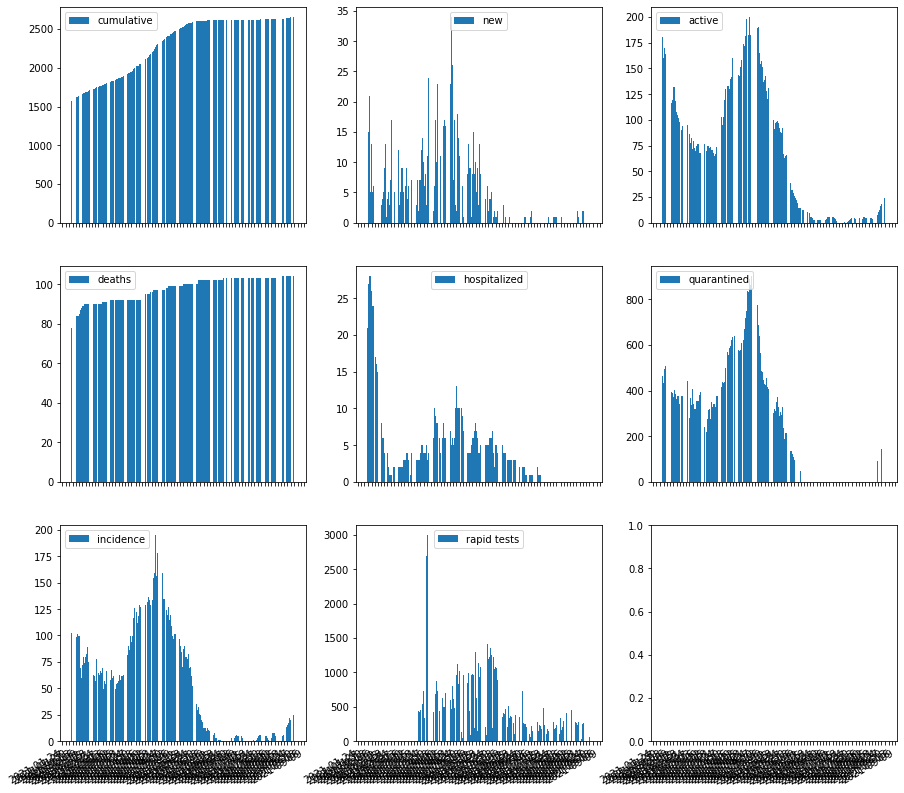

In [2]:
fig,axes = plt.subplots(3,3, sharex=True, figsize=(15,15))
for l,ax,label in zip([cum_inf,
                       new_inf,
                       act_inf,
          #rec,
          deaths,hosp,quar,inc,
          #causes,
              rapid_test],axes.flat,['cumulative','new','active','deaths','hospitalized','quarantined','incidence','rapid tests']):
    #ax.plot(date_list,l, label=label, ls='none', marker='.')
    ax.bar(date_list, l, label=label)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.DayLocator((3,6,9,12,15,18,21,24,27,30)))
    
fig.autofmt_xdate()

error:  25  Falkschule)
error:  51  1 noch nicht ermittelt
error:  74  darunter auch betroffene Weimarer Einrichtungen
error:  74  finden Sie hier: https://bildung.thueringen.de/ministerium/coronavirus/ticker#c31282 
1 Umfeld Flüchtlingsunterkunft)
error:  91 ist unklar. 
2021-05-15 Ansteckungsursache: Arbeitsumfeld) aus den vergangenen Tagen.
error:  102 beitsumfeld) aus den vergangenen Tagen.
error:  119 beitsumfeld
error:  122 bekannt.
error:  124 ist unklar. 
error:  126 Familie
error:  134 ist unbekannt.


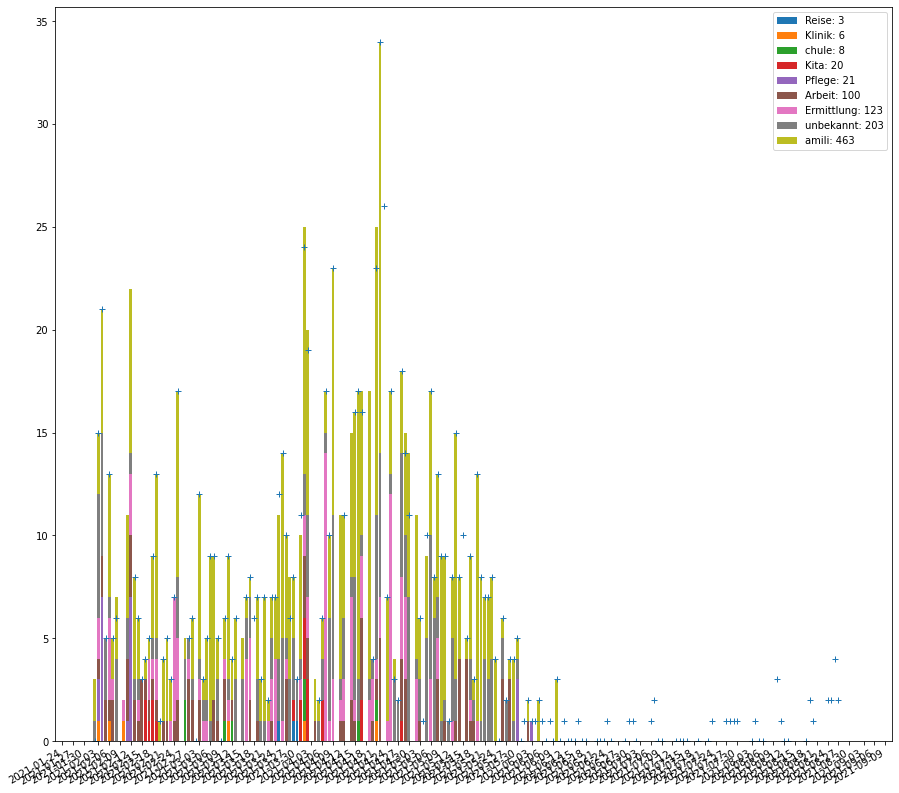

In [3]:

cause_categories = ['amili','Freundeskreis','Haushalt','Reise','Arbeit','unbekannt','unklar','Ermittlung','ermittel','Kita','KiTa','chule','Klinik','Pflege','Reha','Physiotherapie']
category_indices = [0,         0,              0,        1,       2,       3,          3,       4,          4,           5,    5,      6,      7,      8,           7,     7]

causes_categorized = np.zeros((len(causes),max(category_indices)+1), dtype=int)

for day,causes_day in enumerate(causes):
    if day==102:print(date_list[day],causes_day)
    if not causes_day:
        continue
    causes_day = causes_day.lstrip('Ansteckungsursachen: ').lstrip('Ansteckungsursache: ')
    causes_day = causes_day.split(',')
    for cause_day in causes_day:
        try:
            num, cause = cause_day.split('x ')[:2]
        except ValueError:
            print('error: ',day, cause_day)
            continue
        num=int(num.strip('x'))
        cause = cause.strip('.')
        for index, category in zip(category_indices,cause_categories):
            if category in cause:
                break
        else:
            print(num, cause)
        #if day==102: print(num,cause,cause_categories[category_indices.index(index)])
        causes_categorized[day,index]+=num

cum= np.cumsum(causes_categorized,axis=1)

plt.figure(figsize=(15,15))
last = np.zeros_like(causes_categorized[:,0])
sorted_indices = list(range(max(category_indices)+1))
sorted_indices.sort(key=lambda i: np.sum(causes_categorized[:,i]))

for i in sorted_indices:
    category = cause_categories[category_indices.index(i)]
    this = causes_categorized[:,i]
    plt.bar(date_list, causes_categorized[:,i],bottom=last, label=category+f': {np.sum(this)}')
    last+=this
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.DayLocator((3,6,9,12,15,18,21,24,27,30)))
    
plt.plot(date_list,new_inf, ls='none',marker='+')
plt.gcf().autofmt_xdate()

['2021-08-25' '2021-08-26' '2021-08-27' '2021-08-28' '2021-08-29'
 '2021-08-30' '2021-08-31']
[2 4 2 nan nan nan nan]
[16.86 21.46 19.93 nan nan 24.53 nan]
[17.6291141  20.69504699 22.22801343 23.37773826 24.14422148 24.52746309
 24.52746309]
[17.6291141  20.69504699 22.22801343 24.52746309 24.52746309] ['2021-08-25' '2021-08-26' '2021-08-27' '2021-08-30' '2021-08-31']


ValueError: x and y must have same first dimension, but have shapes (205,) and (211,)

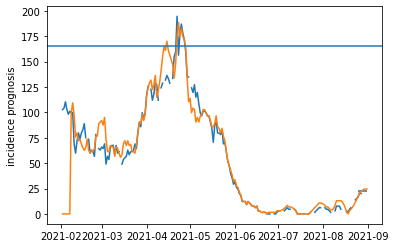

<Figure size 432x288 with 0 Axes>

In [4]:
new_inf_interp = new_inf.astype(float)
ok = ~np.isnan(new_inf_interp)
xp = ok.ravel().nonzero()[0]
fp = new_inf_interp[~np.isnan(new_inf_interp)]
x  = np.isnan(new_inf_interp).ravel().nonzero()[0]

new_inf_interp[np.isnan(new_inf_interp)] = np.interp(x, xp, fp)


residents = 65233

inc_comp=np.convolve(new_inf_interp,np.ones(7),"valid")/residents*100000
inc_comp = np.concatenate((np.zeros(6),inc_comp))
plt.plot(date_list,inc)
plt.plot(date_list,inc_comp)

print(date_list[-7:])
print(new_inf[-7:])
print(inc[-7:])
print(inc_comp[-7:])


def open_close(new_inf_progn, date_list_progn,lkdn_fact=1):
    # number of infections are modeled with a poisson distribution
    last_week = new_inf_progn[-14:]
    lamdam = np.mean(last_week)*lkdn_fact
    lamdav = np.var(last_week)*lkdn_fact
    lamda=lamdam#np.mean((lamdam,lamdav))
#     lamda=np.mean((lamdam,lamdav))
#     print(lamdam ,lamdav)
    rg = np.random.default_rng()
    
    incidences = np.convolve(new_inf_progn,np.ones(7),"valid")/residents*100000
    date_list_progn = date_list_progn[-incidences.size:]
    incidences = incidences[np.is_busday(date_list_progn)][-5:] # 5 business days
#     current_incidence = np.sum(last_week)/residents*100000
#     print(incidences[-5:],current_incidence)
    print(incidences,date_list[np.is_busday(date_list)][-5:])
    if (incidences>= 35).any():
#         incidences[-1] = current_incidence
        while True:
            # prognose new infections
            
#             lamda = np.mean(last_week)*lkdn_fact
            prog_inf = rg.poisson(lamda,(1,))
            new_inf_progn = np.concatenate((new_inf_progn,prog_inf))
            
            date_list_progn = np.concatenate((date_list_progn, date_list_progn[-1:]+np.timedelta64(1,"D")))
            
            if not np.is_busday(date_list_progn[-1]):
                continue
            else: print(date_list_progn[-1])
            #compute incidences
            last_week = new_inf_progn[-7:]
            incidences = np.roll(incidences, -1)
            incidences[-1] = np.sum(last_week)/residents*100000
#             print(incidences)
            if date_list_progn[-1]>np.datetime64('2021-06-30','D'):
                break
            if (incidences< 165).all():
                
                # overnext day
                prog_inf = rg.poisson(lamda,(1,))
                new_inf_progn = np.concatenate((new_inf_progn,prog_inf))
                date_list_progn = np.concatenate((date_list_progn, date_list_progn[-1:]+np.timedelta64(1,"D")))
                break
                
    while not np.is_busday(date_list_progn[-1]):
        prog_inf = rg.poisson(lamda,(1,))
        new_inf_progn = np.concatenate((new_inf_progn,prog_inf))
        date_list_progn = np.concatenate((date_list_progn, date_list_progn[-1:]+np.timedelta64(1,"D")))

    return date_list_progn, new_inf_progn


plt.axhline(165)
plt.hlines(xmin=date_list[-7],xmax=date_list[-1],y=np.mean(inc_comp[-7:]))
ax_inc = plt.gca()
plt.ylabel("incidence prognosis")
plt.figure()
num_samples = 10
all_dates = np.zeros(num_samples,dtype='datetime64[D]')
for i in range(num_samples):
    date_list_progn, new_inf_progn = open_close(np.copy(new_inf_interp), np.copy(date_list),1+np.random.rand()*0.1)    
    all_dates[i]=date_list_progn[-1]
    
    inc_comp=np.convolve(new_inf_progn,np.ones(7),"valid")/residents*100000
    inc_comp = np.concatenate((np.zeros(6),inc_comp))
    ax_inc.plot(date_list_progn,inc_comp, alpha=.1, color='k')
    
    plt.plot(date_list_progn,new_inf_progn, alpha=.1, color='k')

ax_inc.set_xlim(xmin=datetime.datetime.today()-datetime.timedelta(days=7))
plt.xlim(xmin=datetime.datetime.today()-datetime.timedelta(days=7))
plt.ylabel("new infections per day")
plt.gcf().autofmt_xdate()
plt.figure()
plt.hist(all_dates, bins=50, density=True)
plt.ylabel("opening probability")
plt.gcf().autofmt_xdate()